# Bayesian Neural Network (VI) for regression

### Zhenwen Dai (2018-8-21)

```
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License").
#   You may not use this file except in compliance with the License.
#   A copy of the License is located at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   or in the "license" file accompanying this file. This file is distributed
#   on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#   express or implied. See the License for the specific language governing
#   permissions and limitations under the License.
# ==============================================================================
```

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference

### Generate Synthetic Data

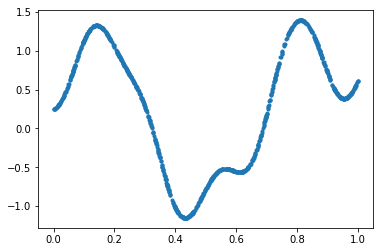

In [2]:
import GPy
%matplotlib inline
from pylab import *

np.random.seed(0)
k = GPy.kern.RBF(1, lengthscale=0.1)
x = np.random.rand(1000,1)
y = np.random.multivariate_normal(mean=np.zeros((1000,)), cov=k.K(x), size=(1,)).T
plot(x[:,0], y[:,0], '.')

## Model definition

In [3]:
D = 50
net = nn.HybridSequential(prefix='nn_')
with net.name_scope():
    net.add(nn.Dense(D, activation="tanh", in_units=1))
    net.add(nn.Dense(D, activation="tanh", in_units=D))
    net.add(nn.Dense(1, flatten=True, in_units=D))
net.initialize(mx.init.Xavier(magnitude=3))

In [4]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion.inference import VariationalPosteriorForwardSampling
from mxfusion.components.functions.operators import broadcast_to
from mxfusion.components.distributions import Normal
from mxfusion import Variable, Model
from mxfusion.components.functions import MXFusionGluonFunction

In [5]:
m = Model()
m.N = Variable()
m.f = MXFusionGluonFunction(net, num_outputs=1,broadcastable=False)
m.x = Variable(shape=(m.N,1))
m.v = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
m.r = m.f(m.x)
for v in m.r.factor.parameters.values():
    v.set_prior(Normal(mean=broadcast_to(mx.nd.array([0]), v.shape),
                       variance=broadcast_to(mx.nd.array([1.]), v.shape)))
m.y = Normal.define_variable(mean=m.r, variance=broadcast_to(m.v, (m.N,1)), shape=(m.N,1))
print(m)

Model (a0f1e)
Variable(b08ec) = BroadcastToOperator(data=Variable(6c09d))
Variable(1cdae) = BroadcastToOperator(data=Variable(20ed6))
Variable(f6567) ~ Normal(mean=Variable(1cdae), variance=Variable(b08ec))
Variable(11427) = BroadcastToOperator(data=Variable(cb51c))
Variable(6068d) = BroadcastToOperator(data=Variable(a397c))
Variable(0d566) ~ Normal(mean=Variable(6068d), variance=Variable(11427))
Variable(a2806) = BroadcastToOperator(data=Variable(37171))
Variable(64e44) = BroadcastToOperator(data=Variable(58b81))
Variable(591da) ~ Normal(mean=Variable(64e44), variance=Variable(a2806))
Variable(04dac) = BroadcastToOperator(data=Variable(56e87))
Variable(a1d30) = BroadcastToOperator(data=Variable(e500b))
Variable(1caf4) ~ Normal(mean=Variable(a1d30), variance=Variable(04dac))
Variable(7a6fd) = BroadcastToOperator(data=Variable(39c80))
Variable(2bf77) = BroadcastToOperator(data=Variable(2d483))
Variable(c555f) ~ Normal(mean=Variable(2bf77), variance=Variable(7a6fd))
Variable(9c33c) = Bro

## Inference with Meanfield

In [6]:
from mxfusion.inference import BatchInferenceLoop, create_Gaussian_meanfield, GradBasedInference, StochasticVariationalInference

In [7]:
observed = [m.y, m.x]
q = create_Gaussian_meanfield(model=m, observed=observed)
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [8]:
infr.initialize(y=mx.nd.array(y), x=mx.nd.array(x))

In [9]:
for v_name, v in m.r.factor.parameters.items():
    infr.params[q[v].factor.mean] = net.collect_params()[v_name].data()
    infr.params[q[v].factor.variance] = mx.nd.ones_like(infr.params[q[v].factor.variance])*1e-6

In [10]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(y), x=mx.nd.array(x), verbose=True)

Iteration 201 loss: 15813.8652343755
Iteration 401 loss: 11816.2539062575
Iteration 601 loss: 8878.53613281255
Iteration 801 loss: 6882.62353515625
Iteration 1001 loss: 4587.8847656255
Iteration 1201 loss: 3141.453613281255
Iteration 1401 loss: 2384.0412597656255
Iteration 1601 loss: 1506.3929443359375
Iteration 1801 loss: 1371.0905761718755
Iteration 2000 loss: 1076.2847900390625

## Use prediction to visualize the resulting BNN

In [11]:
xt = np.linspace(0,1,100)[:,None]

In [12]:
infr2 = VariationalPosteriorForwardSampling(10, [m.x], infr, [m.r])
res = infr2.run(x=mx.nd.array(xt))

In [13]:
yt = res[0].asnumpy()

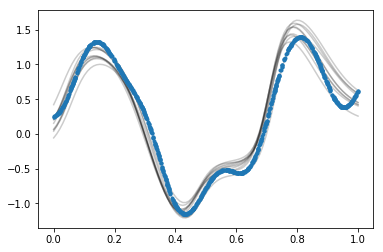

In [14]:
yt_mean = yt.mean(0)
yt_std = yt.std(0)

for i in range(yt.shape[0]):
    plot(xt[:,0],yt[i,:,0],'k',alpha=0.2)
plot(x[:,0],y[:,0],'.')